In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt



In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


# Outlyers Handling 

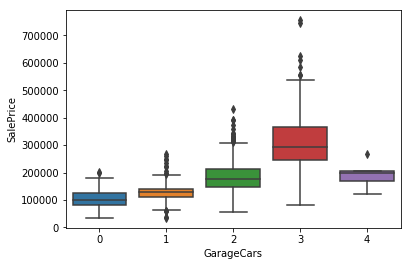

In [4]:
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


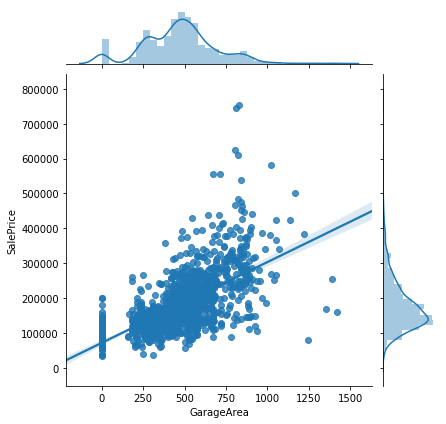

In [5]:
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

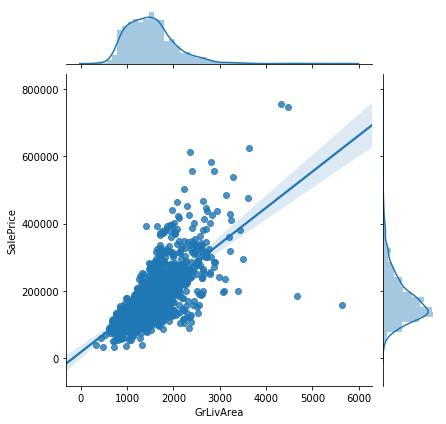

In [6]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

# Data set spliting

In [7]:
train_raw_labels = train['SalePrice'].to_frame().as_matrix()
ntrain = train.shape[0]
ntest = test.shape[0]

train_labels=np.log(train['SalePrice'].values)
concated_dataset = pd.concat((train, test)).reset_index(drop=True)
concated_dataset.drop(['SalePrice'], axis=1, inplace=True)
nconcated=concated_dataset.shape[0]
print("Concated dataset shape",concated_dataset.shape,"train",train.shape,"test",test.shape)


Concated dataset shape (2919, 79) train (1460, 80) test (1459, 79)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [8]:
train_post = concated_dataset.iloc[0:1460,:]
test_post = concated_dataset.iloc[1460:2919,:]

# Distribution visualization
Reference:5

In [9]:
import math
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p

In [10]:
def plot_df_countplots(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes == 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            if col_idx < len(_columns):
                col = _columns[col_idx]
                
                sns.countplot(df[col], ax=axes[r_idx][c_idx])
                axes[r_idx][c_idx].set_title(col)
                for item in axes[r_idx][c_idx].get_xticklabels():
                    item.set_rotation(45)
    
    plt.tight_layout()
    plt.show()

In [11]:

def plot_df_distributions(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes != 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*3.5,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            
            if col_idx < len(_columns):
                col = _columns[col_idx]
                sns.distplot(df[col], ax=axes[r_idx][c_idx], fit=norm)
    
    plt.tight_layout()
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


ValueError: cannot convert float NaN to integer

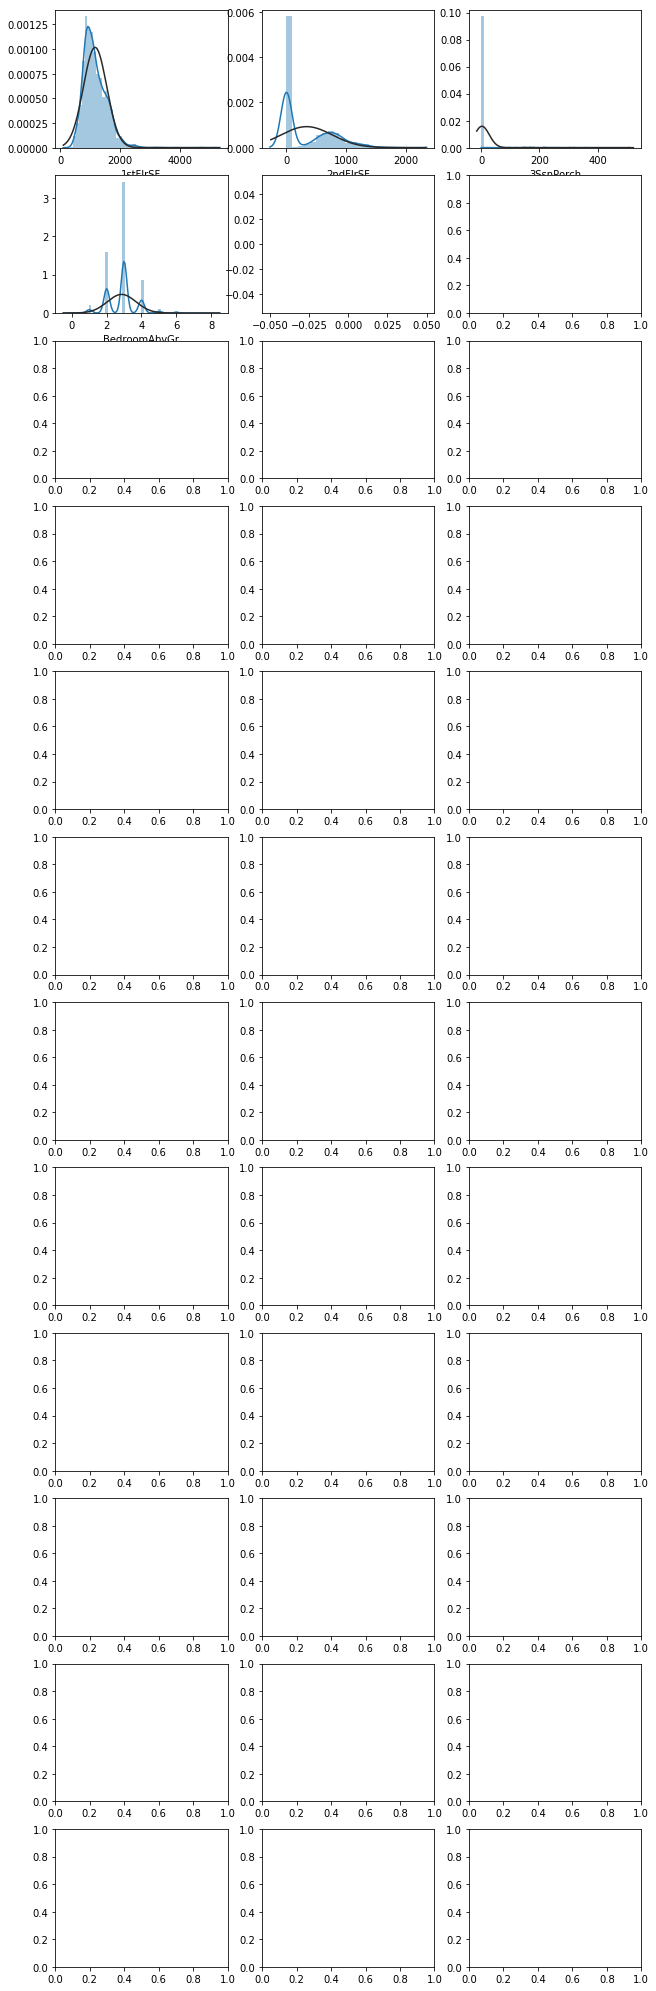

In [12]:
plot_df_distributions(concated_dataset, num_cols=3)


# Dealing with missing data

In [10]:
all_data_na = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


From the list we can begin working with data filling.First let check what is PoolQC and why this is empthy.This have four values Ex=Excellent,Gd=Good,TA=typical,Fa=Fair,NA=no pool.So may be missing data should be NA.Lets also help our model by just replacing with neumerical values I will give Ex=4 and No Pool=0. Since the saleprice should be higher if the PoolQC is more.

In [11]:
concated_dataset["PoolQC"] = concated_dataset["PoolQC"].fillna(0)
concated_dataset["PoolQC"] =concated_dataset["PoolQC"].replace(to_replace={"Ex": 4, "Gd":3,"TA":2,"Fa":1})


Lets verify 

In [12]:
for i in concated_dataset["PoolQC"] :
    if i !=0:
        print(i)

4
1
3
4
3
1
3
4
4
3


Now this looks good. Now we can investigate next feature. Which MiscFeature is 96% missing data.This has Elev {Elevator}, Gar2 {2nd Garage} ,Othr {Other},Shed {Shed (over 100 SF}TenC {Tennis Court},NA   {None} values.But we can but keep NA lets replace. We also need to make it catagorical at some point.

In [13]:
concated_dataset["MiscFeature"] = concated_dataset["MiscFeature"].fillna("None")


In [14]:
concated_dataset["MiscFeature"]=pd.Categorical(concated_dataset["MiscFeature"])

In [15]:
dfDummies_MiscFeature = pd.get_dummies(concated_dataset["MiscFeature"], prefix = 'MiscFeature')
concated_dataset = pd.concat([concated_dataset,dfDummies_MiscFeature ], axis=1)
concated_dataset = concated_dataset.drop(['MiscFeature'], axis=1)


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
lbl = LabelEncoder() 


Now lets fill up Alley.This can be of 3 types Gravel, paved and No Alley which means NA will have different meaning.

In [17]:
concated_dataset["Alley"] = concated_dataset["Alley"].fillna("None")
concated_dataset["Alley"] =concated_dataset["Alley"].replace(to_replace={"Grvl": 2, "Pave":1,"None":0})


In [23]:
concated_dataset["Fence"] = concated_dataset["Fence"].fillna("None")



KeyError: 'Fence'

In [24]:
concated_dataset["Fence"] =pd.Categorical(concated_dataset["Fence"])
dfDummies_Fence = pd.get_dummies(concated_dataset["Fence"], prefix = 'Fence')
concated_dataset = pd.concat([concated_dataset, dfDummies_Fence], axis=1)
concated_dataset = concated_dataset.drop(['Fence'], axis=1)


KeyError: 'Fence'

Now lets find out how to encode fireplace. From the descreption 
   Ex   Excellent - Exceptional Masonry Fireplace
   Gd   Good - Masonry Fireplace in main level
   TA   Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
   Fa   Fair - Prefabricated Fireplace in basement
   Po   Poor - Ben Franklin Stove
   NA   No Fireplace
So we can replace Ex with 5 and NA with 0.


In [25]:
concated_dataset["FireplaceQu"] = concated_dataset["FireplaceQu"].fillna("None")
concated_dataset["FireplaceQu"] =concated_dataset["FireplaceQu"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

LotFrontage: Linear feet of street connected to property.NA probably means not given. LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [26]:
concated_dataset["LotFrontage"] = concated_dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


In [27]:
print(concated_dataset["LotFrontage"])

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
5        85.0
6        75.0
7        80.0
8        51.0
9        50.0
10       70.0
11       85.0
12       72.0
13       91.0
14       73.0
15       51.0
16       73.0
17       72.0
18       66.0
19       70.0
20      101.0
21       57.0
22       75.0
23       44.0
24       72.0
25      110.0
26       60.0
27       98.0
28       47.0
29       60.0
        ...  
2889     50.0
2890     75.0
2891     69.0
2892     50.0
2893     60.0
2894     41.0
2895     44.0
2896     69.0
2897     65.0
2898     70.0
2899    140.0
2900     82.0
2901     82.0
2902     95.0
2903     88.0
2904    125.0
2905     78.0
2906     41.0
2907     58.0
2908     74.0
2909     21.0
2910     21.0
2911     80.0
2912     21.0
2913     21.0
2914     21.0
2915     21.0
2916    160.0
2917     62.0
2918     74.0
Name: LotFrontage, Length: 2919, dtype: float64


GarageType, GarageFinish, GarageQual, GarageCond is NA if no Garage is there. NA should be replaced with None.

In [28]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    concated_dataset[col] = concated_dataset[col].fillna('None')

Like previous I will fill up manually since this will help the netwok to tune easily. 

In [29]:
concated_dataset["GarageFinish"] =concated_dataset["GarageFinish"].replace(to_replace={"Fin": 3, "RFn":2,"Unf":1,"None":0})


In [31]:
concated_dataset["GarageQual"] =concated_dataset["GarageQual"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


In [32]:
concated_dataset["GarageCond"] =concated_dataset["GarageCond"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


In [34]:
concated_dataset["GarageType"]=pd.Categorical(concated_dataset["GarageType"])

In [35]:
dfDummies_GarageType = pd.get_dummies(concated_dataset["GarageType"], prefix = 'GarageType')


In [36]:
concated_dataset = pd.concat([concated_dataset, dfDummies_GarageType], axis=1)
concated_dataset = concated_dataset.drop(['GarageType'], axis=1)


In [37]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,Fence_MnPrv,Fence_MnWw,Fence_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,856,854,0,0,3,1Fam,TA,No,706.0,0.0,...,0,0,1,0,1,0,0,0,0,0
1,1262,0,0,0,3,1Fam,TA,Gd,978.0,0.0,...,0,0,1,0,1,0,0,0,0,0
2,920,866,0,0,3,1Fam,TA,Mn,486.0,0.0,...,0,0,1,0,1,0,0,0,0,0
3,961,756,0,0,3,1Fam,Gd,No,216.0,0.0,...,0,0,1,0,0,0,0,0,1,0
4,1145,1053,0,0,4,1Fam,TA,Av,655.0,0.0,...,0,0,1,0,1,0,0,0,0,0


In [38]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    concated_dataset[col] = concated_dataset[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    concated_dataset[col] = concated_dataset[col].fillna(0)

In [39]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    concated_dataset[col] = concated_dataset[col].fillna('None')

In [40]:
concated_dataset["BsmtQual"] =concated_dataset["BsmtQual"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


In [41]:
concated_dataset["BsmtCond"] =concated_dataset["BsmtCond"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


In [42]:
concated_dataset["BsmtExposure"] =concated_dataset["BsmtExposure"].replace(to_replace={"Gd":3,"Av":2,"Mn":1,"No":0,"None":0})


In [43]:
concated_dataset["BsmtFinType1"] =concated_dataset["BsmtFinType1"].replace(to_replace={"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"None":0})
concated_dataset["BsmtFinType2"] =concated_dataset["BsmtFinType2"].replace(to_replace={"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"None":0})


In [45]:
concated_dataset["MasVnrType"] = concated_dataset["MasVnrType"].fillna("None")
concated_dataset["MasVnrArea"] = concated_dataset["MasVnrArea"].fillna(0)

In [46]:
concated_dataset["MasVnrType"]=pd.Categorical(concated_dataset["MasVnrType"])
dfDummies_MasVnrType = pd.get_dummies(concated_dataset["MasVnrType"], prefix = 'MasVnrType')
concated_dataset = pd.concat([concated_dataset, dfDummies_MasVnrType], axis=1)
concated_dataset = concated_dataset.drop(['MasVnrType'], axis=1)


In [47]:
concated_dataset.select_dtypes(include=['object']).columns


Index(['BldgType', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation',
       'Functional', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning',
       'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [48]:
concated_dataset['MSZoning'] = concated_dataset['MSZoning'].fillna(concated_dataset['MSZoning'].mode()[0])


In [49]:
concated_dataset["MSZoning"]=pd.Categorical(concated_dataset["MSZoning"])
dfDummies_MSZoning = pd.get_dummies(concated_dataset["MSZoning"], prefix = 'MSZoning')
concated_dataset = pd.concat([concated_dataset, dfDummies_MSZoning], axis=1)
concated_dataset = concated_dataset.drop(['MSZoning'], axis=1)


In [50]:
concated_dataset["Utilities"] = concated_dataset["Utilities"].fillna("None")


In [51]:
concated_dataset["Utilities"]=pd.Categorical(concated_dataset["Utilities"])
dfDummies_Utilities = pd.get_dummies(concated_dataset["Utilities"], prefix = 'Utilities')
concated_dataset = pd.concat([concated_dataset, dfDummies_Utilities], axis=1)
concated_dataset = concated_dataset.drop(['Utilities'], axis=1)


In [52]:
concated_dataset["Functional"] = concated_dataset["Functional"].fillna("Typ")


In [53]:
concated_dataset["Functional"] =concated_dataset["Functional"].replace(to_replace={"Typ": 8, "Min1":7,"Min2":6,"Mod":5,"Maj1":4,"Maj2":3,"Sev":2,"Sal":1})


In [54]:
concated_dataset['Electrical'] = concated_dataset['Electrical'].fillna(concated_dataset['Electrical'].mode()[0])


In [55]:
concated_dataset["Electrical"]=pd.Categorical(concated_dataset["Electrical"])
dfDummies_Electrical = pd.get_dummies(concated_dataset["Electrical"], prefix = 'Electrical')
concated_dataset = pd.concat([concated_dataset, dfDummies_Electrical], axis=1)
concated_dataset = concated_dataset.drop(['Electrical'], axis=1)


In [56]:
concated_dataset['KitchenQual'] = concated_dataset['KitchenQual'].fillna(concated_dataset['KitchenQual'].mode()[0])


In [57]:
concated_dataset["KitchenQual"] =concated_dataset["KitchenQual"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


In [58]:
concated_dataset['Exterior1st'] = concated_dataset['Exterior1st'].fillna(concated_dataset['Exterior1st'].mode()[0])
concated_dataset['Exterior2nd'] = concated_dataset['Exterior2nd'].fillna(concated_dataset['Exterior2nd'].mode()[0])

In [59]:
concated_dataset["Exterior1st"]=pd.Categorical(concated_dataset["Exterior1st"])
dfDummies_Exterior1st = pd.get_dummies(concated_dataset["Exterior1st"], prefix = 'Exterior1st')
concated_dataset = pd.concat([concated_dataset, dfDummies_Exterior1st], axis=1)
concated_dataset = concated_dataset.drop(['Exterior1st'], axis=1)


In [60]:
concated_dataset["Exterior2nd"]=pd.Categorical(concated_dataset["Exterior2nd"])
dfDummies_Exterior2nd = pd.get_dummies(concated_dataset["Exterior2nd"], prefix = 'Exterior2nd')
concated_dataset = pd.concat([concated_dataset, dfDummies_Exterior2nd], axis=1)
concated_dataset = concated_dataset.drop(['Exterior2nd'], axis=1)


In [61]:
concated_dataset['SaleType'] = concated_dataset['SaleType'].fillna(concated_dataset['SaleType'].mode()[0])


In [62]:
concated_dataset["SaleType"]=pd.Categorical(concated_dataset["SaleType"])
dfDummies_SaleType = pd.get_dummies(concated_dataset["SaleType"], prefix = 'SaleType')
concated_dataset = pd.concat([concated_dataset, dfDummies_SaleType], axis=1)
concated_dataset = concated_dataset.drop(['SaleType'], axis=1)


In [63]:
concated_dataset['MSSubClass'] = concated_dataset['MSSubClass'].astype(str)
concated_dataset['MSSubClass'] = concated_dataset['MSSubClass'].fillna(concated_dataset['MSSubClass'].mode()[0])



In [64]:
concated_dataset["MSSubClass"]=pd.Categorical(concated_dataset["MSSubClass"])
dfDummies_MSSubClass = pd.get_dummies(concated_dataset["MSSubClass"], prefix = 'MSSubClass')
concated_dataset = pd.concat([concated_dataset, dfDummies_MSSubClass], axis=1)
concated_dataset = concated_dataset.drop(['MSSubClass'], axis=1)


# check for missing data

In [65]:
all_data_na = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


In [66]:
concated_dataset.select_dtypes(include=['object']).columns


Index(['BldgType', 'CentralAir', 'Condition1', 'Condition2', 'ExterCond',
       'ExterQual', 'Foundation', 'Heating', 'HeatingQC', 'HouseStyle',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'Neighborhood',
       'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'Street'],
      dtype='object')

In [67]:
concated_dataset["BldgType"]=pd.Categorical(concated_dataset["BldgType"])
dfDummies_BldgType = pd.get_dummies(concated_dataset["BldgType"], prefix = 'BldgType')
concated_dataset = pd.concat([concated_dataset, dfDummies_BldgType], axis=1)
concated_dataset = concated_dataset.drop(['BldgType'], axis=1)


In [68]:
concated_dataset["CentralAir"] =concated_dataset["CentralAir"].replace(to_replace={"N": 5, "Y":4})


In [69]:
concated_dataset["Condition1"]=pd.Categorical(concated_dataset["Condition1"])
dfDummies_condition1 = pd.get_dummies(concated_dataset["Condition1"], prefix = 'Condition1')
concated_dataset = pd.concat([concated_dataset, dfDummies_condition1], axis=1)
concated_dataset = concated_dataset.drop(['Condition1'], axis=1)


In [70]:
concated_dataset["Condition2"]=pd.Categorical(concated_dataset["Condition2"])
dfDummies_condition2 = pd.get_dummies(concated_dataset["Condition2"], prefix = 'Condition2')
concated_dataset = pd.concat([concated_dataset, dfDummies_condition2], axis=1)
concated_dataset = concated_dataset.drop(['Condition2'], axis=1)


In [71]:
concated_dataset["ExterCond"] =concated_dataset["ExterCond"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


In [72]:
concated_dataset["ExterQual"] =concated_dataset["ExterQual"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1,"None":0})


In [73]:
concated_dataset["Foundation"]=pd.Categorical(concated_dataset["Foundation"])
dfDummies_Foundation = pd.get_dummies(concated_dataset["Foundation"], prefix = 'Foundation')
concated_dataset = pd.concat([concated_dataset, dfDummies_Foundation], axis=1)
concated_dataset = concated_dataset.drop(['Foundation'], axis=1)


In [74]:
concated_dataset["Heating"]=pd.Categorical(concated_dataset["Heating"])
dfDummies_Heating = pd.get_dummies(concated_dataset["Heating"], prefix = 'Heating')
concated_dataset = pd.concat([concated_dataset, dfDummies_Heating], axis=1)
concated_dataset = concated_dataset.drop(['Heating'], axis=1)


In [75]:
concated_dataset["HeatingQC"] =concated_dataset["HeatingQC"].replace(to_replace={"Ex": 5, "Gd":4,"TA":3,"Fa":2,"Po":1})


In [76]:
concated_dataset["HouseStyle"]=pd.Categorical(concated_dataset["HouseStyle"])
dfDummies_HouseStyle = pd.get_dummies(concated_dataset["HouseStyle"], prefix = 'HouseStyle')
concated_dataset = pd.concat([concated_dataset, dfDummies_HouseStyle], axis=1)
concated_dataset = concated_dataset.drop(['HouseStyle'], axis=1)


In [77]:
concated_dataset["LandContour"]=pd.Categorical(concated_dataset["LandContour"])
dfDummies_LandContour = pd.get_dummies(concated_dataset["LandContour"], prefix = 'LandContour')
concated_dataset = pd.concat([concated_dataset, dfDummies_LandContour], axis=1)
concated_dataset = concated_dataset.drop(['LandContour'], axis=1)


In [78]:
concated_dataset["LandSlope"]=pd.Categorical(concated_dataset["LandSlope"])
dfDummies_LandSlope = pd.get_dummies(concated_dataset["LandSlope"], prefix = 'LandSlope')
concated_dataset = pd.concat([concated_dataset, dfDummies_LandSlope], axis=1)
concated_dataset = concated_dataset.drop(['LandSlope'], axis=1)


In [79]:
concated_dataset["LotConfig"]=pd.Categorical(concated_dataset["LotConfig"])
dfDummies_LotConfig = pd.get_dummies(concated_dataset["LotConfig"], prefix = 'LotConfig')
concated_dataset = pd.concat([concated_dataset, dfDummies_LotConfig], axis=1)
concated_dataset = concated_dataset.drop(['LotConfig'], axis=1)


In [80]:
concated_dataset["LotShape"]=pd.Categorical(concated_dataset["LotShape"])
dfDummies_LotShape = pd.get_dummies(concated_dataset["LotShape"], prefix = 'LotShape')
concated_dataset = pd.concat([concated_dataset, dfDummies_LotShape], axis=1)
concated_dataset = concated_dataset.drop(['LotShape'], axis=1)


In [81]:
concated_dataset["Neighborhood"]=pd.Categorical(concated_dataset["Neighborhood"])
dfDummies_Neighborhood = pd.get_dummies(concated_dataset["Neighborhood"], prefix = 'Neighborhood')
concated_dataset = pd.concat([concated_dataset, dfDummies_Neighborhood], axis=1)
concated_dataset = concated_dataset.drop(['Neighborhood'], axis=1)


In [82]:
concated_dataset["PavedDrive"]=pd.Categorical(concated_dataset["PavedDrive"])
dfDummies_PavedDrive = pd.get_dummies(concated_dataset["PavedDrive"], prefix = 'PavedDrive')
concated_dataset = pd.concat([concated_dataset, dfDummies_PavedDrive], axis=1)
concated_dataset = concated_dataset.drop(['PavedDrive'], axis=1)


In [83]:
concated_dataset["RoofMatl"]=pd.Categorical(concated_dataset["RoofMatl"])
dfDummies_RoofMatl = pd.get_dummies(concated_dataset["RoofMatl"], prefix = 'RoofMatl')
concated_dataset = pd.concat([concated_dataset, dfDummies_RoofMatl], axis=1)
concated_dataset = concated_dataset.drop(['RoofMatl'], axis=1)


In [84]:
concated_dataset["RoofStyle"]=pd.Categorical(concated_dataset["RoofStyle"])
dfDummies_RoofStyle = pd.get_dummies(concated_dataset["RoofStyle"], prefix = 'RoofStyle')
concated_dataset = pd.concat([concated_dataset, dfDummies_RoofStyle], axis=1)
concated_dataset = concated_dataset.drop(['RoofStyle'], axis=1)


In [85]:
concated_dataset["SaleCondition"]=pd.Categorical(concated_dataset["SaleCondition"])
dfDummies_SaleCondition = pd.get_dummies(concated_dataset["SaleCondition"], prefix = 'SaleCondition')
concated_dataset = pd.concat([concated_dataset, dfDummies_SaleCondition], axis=1)
concated_dataset = concated_dataset.drop(['SaleCondition'], axis=1)


In [86]:
concated_dataset["Street"]=pd.Categorical(concated_dataset["Street"])
dfDummies_Street = pd.get_dummies(concated_dataset["Street"], prefix = 'Street')
concated_dataset = pd.concat([concated_dataset, dfDummies_Street], axis=1)
concated_dataset = concated_dataset.drop(['Street'], axis=1)


In [87]:
concated_dataset['YrSold'] = concated_dataset['YrSold'].astype(str)
concated_dataset['MoSold'] = concated_dataset['MoSold'].astype(str)

In [88]:
concated_dataset["YrSold"]=pd.Categorical(concated_dataset["YrSold"])
dfDummies_YrSold = pd.get_dummies(concated_dataset["YrSold"], prefix = 'YrSold')
concated_dataset = pd.concat([concated_dataset, dfDummies_YrSold], axis=1)
concated_dataset = concated_dataset.drop(['YrSold'], axis=1)


In [89]:
concated_dataset["MoSold"]=pd.Categorical(concated_dataset["MoSold"])
dfDummies_MoSold = pd.get_dummies(concated_dataset["MoSold"], prefix = 'MoSold')
concated_dataset = pd.concat([concated_dataset, dfDummies_MoSold], axis=1)
concated_dataset = concated_dataset.drop(['MoSold'], axis=1)


In [90]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9
0,856,854,0,0,3,3,0,706.0,0.0,6,...,0,0,1,0,0,0,0,0,0,0
1,1262,0,0,0,3,3,3,978.0,0.0,5,...,0,0,0,0,0,1,0,0,0,0
2,920,866,0,0,3,3,1,486.0,0.0,6,...,0,0,0,0,0,0,0,0,0,1
3,961,756,0,0,3,4,0,216.0,0.0,5,...,0,0,1,0,0,0,0,0,0,0
4,1145,1053,0,0,4,3,2,655.0,0.0,6,...,0,1,0,0,0,0,0,0,0,0


In [91]:
concated_dataset.select_dtypes(include=['object']).columns


Index([], dtype='object')

In [92]:
concated_dataset['TotalSF'] = concated_dataset['TotalBsmtSF'] + concated_dataset['1stFlrSF'] + concated_dataset['2ndFlrSF']

# data Visualization for understanding distribution
Reference:5

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


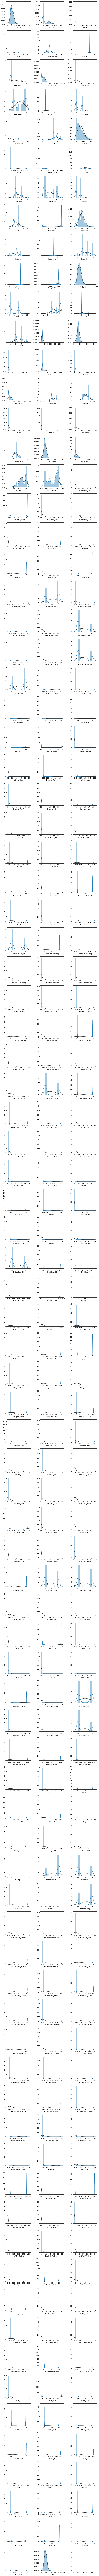

In [91]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,TotalSF
0,856,854,0,0,3,3,0,706.0,0.0,6,...,0,1,0,0,0,0,0,0,0,2566.0
1,1262,0,0,0,3,3,3,978.0,0.0,5,...,0,0,0,0,1,0,0,0,0,2524.0
2,920,866,0,0,3,3,1,486.0,0.0,6,...,0,0,0,0,0,0,0,0,1,2706.0
3,961,756,0,0,3,4,0,216.0,0.0,5,...,0,1,0,0,0,0,0,0,0,2473.0
4,1145,1053,0,0,4,3,2,655.0,0.0,6,...,1,0,0,0,0,0,0,0,0,3343.0


In [92]:
from sklearn.preprocessing import StandardScaler
scaled_features_cn = StandardScaler().fit_transform(concated_dataset.values)
scaled_features_train_postprocess= pd.DataFrame(scaled_features_cn, index=concated_dataset.index, columns=concated_dataset.columns)


In [ ]:
from sklearn.preprocessing import RobustScaler
scaled_features_cn = RobustScaler().fit_transform(concated_dataset.values)
scaled_features_train_postprocess= pd.DataFrame(scaled_features_cn, index=concated_dataset.index, columns=concated_dataset.columns)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaled_features_cn =MinMaxScaler().fit_transform(concated_dataset.values)
scaled_features_train_postprocess= pd.DataFrame(scaled_features_cn, index=concated_dataset.index, columns=concated_dataset.columns)


In [93]:
concated_dataset.select_dtypes(include=['object']).columns


Index([], dtype='object')

In [94]:
train_postprocess = scaled_features_train_postprocess.iloc[0:1460,:]
test_postprocess = scaled_features_train_postprocess.iloc[1460:2919,:]

In [95]:
test_postprocess.shape

(1459, 266)

In [96]:
train_postprocess.shape

(1460, 266)

In [97]:
concated_dataset.shape

(2919, 266)

In [98]:
x_train = train_postprocess.values.astype(np.float32)


In [99]:
x_train.shape

(1460, 266)

In [100]:
assert not np.any(np.isnan(x_train))

In [101]:
y_train=train_labels.astype(np.float32)

In [102]:
x_test = test_postprocess.values.astype(np.float32)
x_test.shape

(1459, 266)

In [103]:
x_train.shape

(1460, 266)

In [104]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(x_train, y_train, test_size=0.1, random_state=40)

In [105]:
m_train,n_train=X_train_val.shape

In [106]:
m_val,n_val=X_test_val.shape

In [107]:
m_test,n_test=x_test.shape

# Clean code with Max norm and early stopping

In [108]:
import tensorflow as tf

In [109]:
from datetime import datetime
from sklearn.preprocessing import StandardScaler


In [110]:
#scalling and adding bias

scaled_x_train_plus_bias = np.c_[np.ones((m_train, 1)),X_train_val]
scaled_x_val_plus_bias = np.c_[np.ones((m_val, 1)),X_test_val]
scaled_x_test_plus_bias = np.c_[np.ones((m_test, 1)),x_test]


In [111]:
# hidden layers neuron numbers, batchsize and epoch number
tf.reset_default_graph()

n_inputs = 267
n_hidden1 = 16
n_hidden2 = 8
n_hidden3=4
n_hidden4=2
n_hidden5=1
n_hidden6=1
n_outputs = 1
n_epochs = 15000 
batch_size = 100


In [112]:
#Learning rate with schedular
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

In [113]:
#Place holder initiallizations
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32,shape=(None), name="y")

In [114]:
#Drop out initializations ,tunable per layer wise 
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate_X = 0.1
dropout_rate_1=0.2
dropout_rate_2=0.2
dropout_rate_3=0.2
dropout_rate_4=0.2
dropout_rate_5=0.05
dropout_rate_6=0.0
X_drop = tf.layers.dropout(X, dropout_rate_X, training=training)
he_init = tf.variance_scaling_initializer()

In [115]:
#max norn fuctions

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

#Threshold tuning option
max_norm_reg = max_norm_regularizer(threshold=1.0)


In [116]:
#Batch normalizaion function and He initializer
from functools import partial
batch_norm_momentum=0.9

he_init = tf.variance_scaling_initializer()

Custom_batch_normalized_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

Custum_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init,kernel_regularizer=max_norm_reg)

In [117]:


with tf.name_scope("dnn"):
    
    #layer1
    hidden1 = Custum_dense_layer(X_drop, n_hidden1,name="hidden1")
    bn1 =  Custom_batch_normalized_layer(hidden1)
    hidden1_bn = tf.nn.elu(bn1)
    hidden1_drop = tf.layers.dropout(hidden1_bn, dropout_rate_1, training=training)
    
    #layer2
    hidden2 =Custum_dense_layer(hidden1_drop, n_hidden2,name="hidden2")
    bn2 = Custom_batch_normalized_layer(hidden2)
    hidden2_bn = tf.nn.elu(bn2)
    hidden2_drop = tf.layers.dropout(hidden2_bn, dropout_rate_2, training=training)
   
    
    #layer3
    hidden3 =Custum_dense_layer( hidden2_drop,n_hidden3,name="hidden3")
    bn3= Custom_batch_normalized_layer(hidden3)
    hidden3_bn = tf.nn.elu(bn3)
    hidden3_drop = tf.layers.dropout(hidden3_bn, dropout_rate_3, training=training)
    

    #layer4
    hidden4 = Custum_dense_layer( hidden3_drop,n_hidden4,name="hidden4")
    bn4= Custom_batch_normalized_layer(hidden4)
    hidden4_n = tf.nn.elu(bn4)
    hidden4_drop= tf.layers.dropout(hidden4_n, dropout_rate_4, training=training)
    
    
    #layer5
    hidden5 = Custum_dense_layer( hidden4_drop,n_hidden5,name="hidden5")
    bn5= Custom_batch_normalized_layer(hidden5)
    hidden5_n = tf.nn.elu(bn5)
    hidden5_drop= tf.layers.dropout(hidden5_n, dropout_rate_5, training=training)

    #layer6
    hidden6 = Custum_dense_layer( hidden5_drop,n_hidden6,name="hidden6")
    bn6= Custom_batch_normalized_layer(hidden6)
    hidden6_n = tf.nn.elu(hidden6)
    hidden6_drop= tf.layers.dropout(hidden6_n,dropout_rate_6, training=training)

    #output
    y_pred_before_BN = Custum_dense_layer(hidden4_drop,n_outputs,name="outputs")
    y_pred=Custom_batch_normalized_layer( y_pred_before_BN)








In [118]:
#Loss calculation and optimizer
error=y_pred-y
mse = tf.reduce_mean(tf.square(error),name="mse")




with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(mse,global_step=global_step)

init = tf.global_variables_initializer()


In [119]:
#batch making and shuffling
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [120]:
#Clipping gradient and saver object
saver = tf.train.Saver()
clip_all_weights=tf.get_collection("max_norm")

In [121]:
#Session with Early stopping mechanism

max_checks_without_progress = 2000
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(scaled_x_train_plus_bias, y_train_val, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)

        loss_val = mse.eval(feed_dict={X: scaled_x_val_plus_bias, y: y_test_val})
        
        
        #Check whether to stop or not
        if loss_val < best_loss:
            save_path = saver.save(sess,"./Final_NUv5.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        #printing at run time
        if epoch %100==0:
            acc_batch = mse.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = mse.eval(feed_dict={X: scaled_x_val_plus_bias, y: y_test_val})
            
            
            
            print("Epoch_number",epoch, "Batch error:", acc_batch, "Val error:", acc_val)
#predict
                
with tf.Session() as sess:
    saver.restore(sess, "./Final_NUv5.ckpt")
    pred=y_pred.eval(feed_dict={X: scaled_x_test_plus_bias})


InternalError: Blas GEMM launch failed : a.shape=(102, 267), b.shape=(267, 16), m=102, n=16, k=267
	 [[node dnn/hidden1/MatMul (defined at <ipython-input-117-b103254927f5>:6)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dropout/cond/Merge, hidden1/kernel/read)]]
	 [[{{node train/Adam/update/_88}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1415_train/Adam/update", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'dnn/hidden1/MatMul', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-117-b103254927f5>", line 6, in <module>
    hidden1 = Custum_dense_layer(X_drop, n_hidden1,name="hidden1")
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\layers\core.py", line 184, in dense
    return layer.apply(inputs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py", line 970, in call
    outputs = gen_math_ops.mat_mul(inputs, self.kernel)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4560, in mat_mul
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(102, 267), b.shape=(267, 16), m=102, n=16, k=267
	 [[node dnn/hidden1/MatMul (defined at <ipython-input-117-b103254927f5>:6)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dropout/cond/Merge, hidden1/kernel/read)]]
	 [[{{node train/Adam/update/_88}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1415_train/Adam/update", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
pred_non_expo=np.exp(pred)

In [ ]:
test_ID.shape

In [ ]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = pred_non_expo

sub.to_csv('submission.csv',index=False)

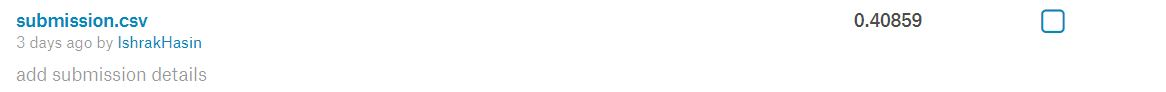

In [122]:
# making object type to apply one hot encodeing

concated_dataset["PoolQC"]=concated_dataset["PoolQC"].apply(str)
concated_dataset["Alley"] = concated_dataset["Alley"].apply(str)
concated_dataset["FireplaceQu"] = concated_dataset["FireplaceQu"].apply(str)
concated_dataset["GarageFinish"] =concated_dataset["GarageFinish"].apply(str)
concated_dataset["GarageQual"] =concated_dataset["GarageQual"].apply(str)
concated_dataset["GarageCond"] =concated_dataset["GarageCond"].apply(str)
concated_dataset["GarageCars"] =concated_dataset["GarageCars"].apply(str)
#GarageYrBlt is too big though to be one hot represented though
concated_dataset["GarageYrBlt"] =concated_dataset["GarageYrBlt"].apply(str)
concated_dataset["BsmtQual"] =concated_dataset["BsmtQual"].apply(str)
concated_dataset["BsmtCond"] =concated_dataset["BsmtCond"].apply(str)
concated_dataset["BsmtExposure"] =concated_dataset["BsmtExposure"].apply(str)
concated_dataset["BsmtFinType1"] =concated_dataset["BsmtFinType1"].apply(str)
concated_dataset["BsmtFinType2"] =concated_dataset["BsmtFinType2"].apply(str)
concated_dataset["Functional"] =concated_dataset["Functional"].apply(str)
concated_dataset["KitchenQual"] =concated_dataset["KitchenQual"].apply(str)
concated_dataset["CentralAir"] =concated_dataset["CentralAir"].apply(str)
concated_dataset["ExterCond"] =concated_dataset["ExterCond"].apply(str)
concated_dataset["ExterQual"] =concated_dataset["ExterQual"].apply(str)
concated_dataset["HeatingQC"] =concated_dataset["HeatingQC"].apply(str)

In [123]:
concated_dataset=pd.get_dummies(concated_dataset)


In [124]:
#Lets print all collumns to deep investigate
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(concated_dataset)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Utilities_AllPub,Utilities_NoSeWa,Utilities_None,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,PavedDrive_N,PavedDrive_P,PavedDrive_Y,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,TotalSF,Alley_0,Alley_1,Alley_2,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,Bsmt

# Lets verify if things are working as expected!!
looking for improvement in performance in same deepnet

In [125]:
from sklearn.preprocessing import RobustScaler
scaled_features_cn2 = RobustScaler().fit_transform(concated_dataset.values)
scaled_features_train_postprocess2= pd.DataFrame(scaled_features_cn2, index=concated_dataset.index, columns=concated_dataset.columns)


In [126]:
train_postprocess2 = scaled_features_train_postprocess2.iloc[0:1460,:]
test_postprocess2 = scaled_features_train_postprocess2.iloc[1460:2919,:]

In [127]:
x_train2 = train_postprocess2.values.astype(np.float32)
x_test2 = test_postprocess2.values.astype(np.float32)



In [128]:
#Spliting train and validation set
from sklearn.model_selection import train_test_split
X_train_val2,X_test_val2,y_train_val2,y_test_val2= train_test_split(x_train2, y_train, test_size=0.05,random_state=40)

In [129]:
#Storing all the necessary shapes
m_train2,n_train2=X_train_val2.shape
m_val2,n_val2=X_test_val2.shape
m_test2,n_test2=x_test2.shape

In [130]:
#scalling and adding bias

scaled_x_train_plus_bias2 = np.c_[np.ones((m_train2, 1)),X_train_val2]
scaled_x_val_plus_bias2 = np.c_[np.ones((m_val2, 1)),X_test_val2]
scaled_x_test_plus_bias2 = np.c_[np.ones((m_test2, 1)),x_test2]

Had to copy the same thing again since I wanted to tune differently and also reseting the default graph without adding with graph.

In [131]:
# hidden layers neuron numbers, batchsize and epoch number
tf.reset_default_graph()

n_inputs = 442
n_hidden1 = 221
n_hidden2 = 111
n_hidden3=55
n_hidden4=13
n_hidden5=8
n_hidden6=4
n_outputs = 1
n_epochs = 15000 
batch_size = 100

In [132]:
#Learning rate with schedular
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

In [133]:
#Place holder initiallizations
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32,shape=(None), name="y")

In [134]:
#Drop out initializations ,tunable per layer wise 
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate_X = 0.1
dropout_rate_1=0.5
dropout_rate_2=0.5
dropout_rate_3=0.5
dropout_rate_4=0.2
dropout_rate_5=0.2
dropout_rate_6=0.1
X_drop = tf.layers.dropout(X, dropout_rate_X, training=training)
he_init = tf.variance_scaling_initializer()

In [135]:
#max norn fuctions

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

#Threshold tuning option
max_norm_reg = max_norm_regularizer(threshold=1.0)


In [136]:
#Batch normalizaion function and He initializer
from functools import partial
batch_norm_momentum=0.9

he_init = tf.variance_scaling_initializer()

Custom_batch_normalized_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

Custum_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init,kernel_regularizer=max_norm_reg)

In [137]:


with tf.name_scope("dnn"):
    
    #layer1
    hidden1 = Custum_dense_layer(X_drop, n_hidden1,name="hidden1")
    bn1 =  Custom_batch_normalized_layer(hidden1)
    hidden1_bn = tf.nn.elu(bn1)
    hidden1_drop = tf.layers.dropout(hidden1_bn, dropout_rate_1, training=training)
    
    #layer2
    hidden2 =Custum_dense_layer(hidden1_drop, n_hidden2,name="hidden2")
    bn2 = Custom_batch_normalized_layer(hidden2)
    hidden2_bn = tf.nn.elu(bn2)
    hidden2_drop = tf.layers.dropout(hidden2_bn, dropout_rate_2, training=training)
   
    
    #layer3
    hidden3 =Custum_dense_layer( hidden2_drop,n_hidden3,name="hidden3")
    bn3= Custom_batch_normalized_layer(hidden3)
    hidden3_bn = tf.nn.elu(bn3)
    hidden3_drop = tf.layers.dropout(hidden3_bn, dropout_rate_3, training=training)
    

    #layer4
    hidden4 = Custum_dense_layer( hidden3_drop,n_hidden4,name="hidden4")
    bn4= Custom_batch_normalized_layer(hidden4)
    hidden4_n = tf.nn.elu(bn4)
    hidden4_drop= tf.layers.dropout(hidden4_n, dropout_rate_4, training=training)
    
    
    #layer5
    hidden5 = Custum_dense_layer( hidden4_drop,n_hidden5,name="hidden5")
    bn5= Custom_batch_normalized_layer(hidden5)
    hidden5_n = tf.nn.elu(bn5)
    hidden5_drop= tf.layers.dropout(hidden5_n, dropout_rate_5, training=training)

    #layer6
    hidden6 = Custum_dense_layer( hidden5_drop,n_hidden6,name="hidden6")
    bn6= Custom_batch_normalized_layer(hidden6)
    hidden6_n = tf.nn.elu(hidden6)
    hidden6_drop= tf.layers.dropout(hidden6_n,dropout_rate_6, training=training)

    #output
    y_pred_before_BN = Custum_dense_layer(hidden6_drop,n_outputs,name="outputs")
    y_pred=Custom_batch_normalized_layer( y_pred_before_BN)








In [138]:
#Loss calculation and optimizer
error=y_pred-y
mse = tf.reduce_mean(tf.square(error),name="mse")




with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(mse,global_step=global_step)

init = tf.global_variables_initializer()

In [139]:
#batch making and shuffling
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [140]:
#Clipping gradient and saver object
saver = tf.train.Saver()
clip_all_weights=tf.get_collection("max_norm")

In [ ]:
#Session with Early stopping mechanism

max_checks_without_progress = 2000
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(scaled_x_train_plus_bias2, y_train_val2, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)

        loss_val = mse.eval(feed_dict={X: scaled_x_val_plus_bias2, y: y_test_val2})
        
        
        #Check whether to stop or not
        if loss_val < best_loss:
            save_path = saver.save(sess,"./Final_NUv62.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        #printing at run time
        if epoch %100==0:
            acc_batch = mse.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = mse.eval(feed_dict={X: scaled_x_val_plus_bias2, y: y_test_val2})
            
            
            
            print("Epoch_number",epoch, "Batch error:", acc_batch, "Val error:", acc_val)
#predict
                
with tf.Session() as sess:
    saver.restore(sess, "./Final_NUv62.ckpt")
    pred=y_pred.eval(feed_dict={X: scaled_x_test_plus_bias2})


In [ ]:
pred_non_expo=np.exp(pred)
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = pred_non_expo

sub.to_csv('Super.csv',index=False)

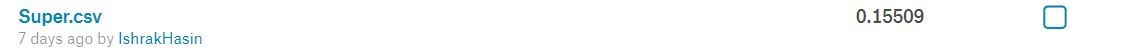

Improvemnt but still it should be much better.This above mentioned model is highly flexible and can be tune according to necessary.We can have a exhustive search on top of that.For both of the models I used Max norm normalization and dropout as regularizer.Kernel is regularized with batch normalization and initialized by he initialization.Dropout rates can be tuned per layer.As activation fuction I used elu instead of relu. This model checks for improvement in validation set for 2000 step if no improvement is found the model stops the training.Since the model is so flexible the next step can be to search over the entire parameter spaces using oscar,randomsearchCV or Grid Search.